In [ ]:
%matplotlib inline


# Step-by-step PyDESeq2 workflow

This notebook details all the steps of the PyDESeq2 pipeline.

It allows you to run the PyDESeq2 pipeline on the synthetic data provided
in this repository.

If this is your first contact with PyDESeq2, we recommend you first have a look at the
:doc:`standard workflow example <plot_minimal_pydeseq2_pipeline>`.
    :depth: 3

We start by importing required packages and setting up an optional path to save
results.


In [9]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be
    # saved
    OUTPUT_PATH = "../output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

## Data loading

Note that we are also explaining this step in the 'getting started' example.
To perform differential expression analysis (DEA), PyDESeq2 requires two types of
inputs:

  * A count matrix of shape 'number of samples' x 'number of genes', containing
    read counts (non-negative integers),
  * Metadata (or "column" data) of shape 'number of samples' x
    'number of variables', containing sample annotations that will be used
    to split the data in cohorts.

Both should be provided as [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

.. currentmodule:: pydeseq2

To illustrate the required data format, we load a synthetic example dataset
that may be
obtained through PyDESeq2's API using :func:`utils.load_example_data`.
You may replace it with your own dataset.



In [4]:
counts_df_name = "gene_counts_DESeq2_65_samples.csv"
metadata_name = "metadata_DESeq2_65_samples.csv"

In [5]:
import pandas as pd

counts_df = pd.read_csv(counts_df_name)
counts_df = counts_df.drop(columns="sample")

metadata = pd.read_csv(metadata_name)

In [115]:
samples_to_keep = ~metadata.condition.isna()
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

In [117]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [18]:
counts_df.head()

,HUNK,KLHL8,ZNF576,UGT1A5,FCF1,SLC2A7,FABP12,TAF12,GLRX,LAMB3,...,ASIC2,TSN,EVA1A,NFATC1,PORCN,GALNT17,DEPDC4,REL,RPL23,AHSP
0,0.0,139.0,52.0,0.0,303.0,0.0,0.0,97.0,110.0,255.0,...,0.0,393.0,0.0,492.0,32.0,0.0,0.0,3464.0,3584.0,1.0
1,0.0,146.0,50.0,0.0,243.0,0.0,0.0,67.0,110.0,298.0,...,0.0,355.0,0.0,380.0,39.0,0.0,0.0,2784.0,2734.0,0.0
2,0.0,35.0,5.0,0.0,63.0,0.0,0.0,14.0,20.0,67.0,...,0.0,55.0,0.0,94.0,2.0,0.0,0.0,484.0,746.0,0.0
3,0.0,72.0,31.0,0.0,138.0,0.0,0.0,50.0,68.0,129.0,...,0.0,155.0,0.0,150.0,11.0,0.0,0.0,2048.0,1699.0,0.0
4,0.0,277.0,95.0,0.0,532.0,0.0,0.0,157.0,184.0,760.0,...,0.0,802.0,0.0,909.0,60.0,0.0,1.0,5576.0,6945.0,1.0


In [7]:
metadata.head()

,sample,condition,group
0,BA029_LPS_08,CL-307,sample
1,BA029_LPS_06,R848,sample
2,BA046_CRX-527_11,CL-307,sample
3,BA028_R848_13,CRX-527,sample
4,BA063_Pam3_17,CRX-527,sample


## 1. Read counts modeling
Read counts modeling with the :class:`DeseqDataSet
<dds.DeseqDataSet>` class

The :class:`DeseqDataSet <dds.DeseqDataSet>` class has two mandatory
arguments, ``counts`` and
``metadata``, as well as a set of optional keyword arguments, among which:

- ``design_factor``: the name of the column of metadata to be used as a design
  variable
- ``refit_cooks``: whether to refit cooks outliers – this is advised, in general.

<div class="alert alert-info"><h4>Note</h4><p>in the case of the provided synthetic data, there won't be any Cooks
  outliers.</p></div>



In [120]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",  # compare samples based on the "condition"
    # column ("B" vs "A")
    refit_cooks=True,
    n_cpus=8,
    ref_level=["condition", "IMDM"],
)

/home/t.afanasyeva/mambaforge/envs/pydeseq2/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Compute normalization factors



In [20]:
dds.fit_size_factors()

dds.obsm["size_factors"]

Fitting size factors...
... done in 0.10 seconds.



array([1.30627057, 1.13689975, 0.23360061, 0.51102742, 2.37649219,
       2.82576291, 1.8931729 , 2.33245001, 0.34671518, 2.38564721,
       1.02550287, 2.5278675 , 0.7921691 , 2.45285771, 0.68407158,
       2.03007751, 1.05316915, 0.22364245, 0.60866439, 0.23690452,
       0.27683849, 0.53806003, 0.43974121, 2.34518502, 1.74698723,
       0.82747016, 1.66394668, 0.7986196 , 0.55887572, 0.63961319,
       1.69635517, 1.19506808, 2.29195503, 0.46949797, 0.50923515,
       0.38423876, 2.49171543, 2.08016378, 0.56084531, 0.527711  ,
       0.82926521, 1.10845191, 1.66062666, 0.50643409, 2.14043223,
       1.11417053, 0.62086856, 0.7164656 , 1.3429895 , 3.30691525,
       2.64463509, 1.66488902, 0.9637909 , 0.57832128, 1.35879028,
       0.55261712, 0.85318571, 1.24367364, 1.29880653, 2.39804637,
       0.79198798, 0.39740795, 0.94392431, 1.18863197, 3.05540923])

### Fit genewise dispersions



In [21]:
dds.fit_genewise_dispersions()

dds.varm["genewise_dispersions"]

Fitting dispersions...
... done in 2.83 seconds.



array([2.11232028e+00, 3.53956693e-02, 2.46829169e-02, ...,
       8.99875492e-02, 3.23526315e-02, 2.09920888e-05])

### Fit dispersion trend coefficients



In [22]:
dds.fit_dispersion_trend()
dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]

Fitting dispersion trend curve...
... done in 3.38 seconds.



array([2.44987545, 0.0476167 , 0.06098   , ..., 0.0402699 , 0.04025831,
       1.83526009])

### Dispersion priors



In [75]:
dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)

logres_prior=0.5780800863217682, sigma_prior=0.5417204551178539


### MAP Dispersions
The `fit_MAP_dispersions` method filters the genes for which dispersion
shrinkage is applied.
Indeed, for genes whose MLE dispersions are too high above the trend curve,
the original MLE value is kept.
The final values of the dispersions that are used for downstream analysis is
stored in `dds.dispersions`.



In [24]:
dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]

Fitting MAP dispersions...
... done in 3.04 seconds.



array([2.22785735, 0.03634803, 0.02882237, ..., 0.08671877, 0.03269853,
       0.69399993])

### Fit log fold changes
Note that in the `DeseqDataSet` object, the log-fold changes are stored in
natural
log scale, but that the results dataframe output by the `summary` method of
`DeseqStats` displays LFCs in log2 scale (see later on).



In [77]:
dds.fit_LFC()
dds.varm["LFC"]

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.87 seconds.

Fitting dispersion trend curve...
... done in 2.94 seconds.

Fitting MAP dispersions...
... done in 4.02 seconds.

Fitting LFCs...
... done in 2.09 seconds.



,intercept,condition_CRX-527_vs_IMDM,condition_Fla-PA_vs_IMDM,condition_LPS_vs_IMDM,condition_LTA_vs_IMDM,condition_PGN_vs_IMDM,condition_Pam3_vs_IMDM,condition_R848_vs_IMDM,condition_CL-307_vs_IMDM
HUNK,-0.569205,-0.569058,-0.790012,-0.416440,-1.112806,-0.430201,-0.392755,-0.668271,0.047764
KLHL8,4.590278,0.109264,-0.137990,-0.009124,-0.005160,0.149964,0.111253,0.179491,0.140748
ZNF576,3.634144,0.039115,0.159445,0.054704,-0.003941,0.012920,-0.062523,-0.034302,0.020472
UGT1A5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF1,5.409261,0.086026,-0.127997,0.039787,-0.064590,0.092064,0.019421,0.021029,-0.017423
...,...,...,...,...,...,...,...,...,...
GALNT17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEPDC4,-1.571799,0.488973,-0.476466,0.522191,-0.110214,-0.396509,0.312834,0.334320,0.627017
REL,7.867861,0.125089,-0.060758,0.041061,-0.079770,0.008605,0.097332,-0.029618,-0.011543
RPL23,7.915493,0.103099,-0.098677,-0.002273,0.077248,0.211613,-0.065583,-0.030344,-0.060623


In [121]:
dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.50 seconds.

Fitting dispersion trend curve...
... done in 2.71 seconds.

Fitting MAP dispersions...
... done in 3.13 seconds.

Fitting LFCs...
... done in 1.86 seconds.

Refitting 6 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



### Calculate Cooks distances and refit
Note that this step is optional.



In [78]:
dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

Refitting 6 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



Save everything



In [ ]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds_detailed_pipe.pkl"), "wb") as f:
        pkl.dump(dds, f)

## 2. Statistical analysis
Statistical analysis with the :class:`DeseqStats <ds.DeseqStats>` class.
The `DeseqDataSet` class has a unique mandatory arguments, `dds`, which should
be a *fitted* `DeseqDataSet` object, as well as a set of optional keyword
arguments, among which:

- `alpha`: the p-value and adjusted p-value significance threshold
- `cooks_filter`: whether to filter p-values based on cooks outliers
- `independent_filter`: whether to perform independent filtering to correct
  p-value trends.



contrast (list or None) – A list of three strings, in the following format: ['variable_of_interest', 'tested_level', 'ref_level']. Names must correspond to the metadata data passed to the DeseqDataSet. E.g., ['condition', 'B', 'A'] will measure the LFC of ‘condition B’ compared to ‘condition A’. For continuous variables, the last two strings should be left empty, e.g. ['measurement', '', '']. If None, the last variable from the design matrix is chosen as the variable of interest, and the reference level is picked alphabetically. (default: ``None).

In [129]:
stat_res = DeseqStats(
    dds,
    contrast=["condition", "LPS", "IMDM"],
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
)

### Wald tests



In [130]:
stat_res.run_wald_test()
stat_res.p_values

Running Wald tests...
... done in 1.54 seconds.



HUNK      0.657216
KLHL8     0.910237
ZNF576    0.553264
FCF1      0.444361
TAF12     0.811804
            ...   
PORCN     0.965258
DEPDC4    0.771398
REL       0.712123
RPL23     0.971573
AHSP      0.898100
Length: 16411, dtype: float64

In [131]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition LPS vs IMDM


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HUNK,0.333285,-0.600593,1.353421,-0.443760,0.657216,0.999914
KLHL8,105.032021,-0.013088,0.116087,-0.112740,0.910237,0.999914
ZNF576,38.228072,0.078332,0.132122,0.592876,0.553264,0.999914
FCF1,230.579997,0.057522,0.075207,0.764849,0.444361,0.999914
TAF12,71.751878,-0.024733,0.103876,-0.238099,0.811804,0.999914
...,...,...,...,...,...,...
PORCN,25.683907,0.007114,0.163330,0.043556,0.965258,0.999914
DEPDC4,0.101185,0.753249,2.592519,0.290547,0.771398,0.999914
REL,2675.101178,0.059233,0.160519,0.369006,0.712123,0.999914
RPL23,2782.508697,-0.003279,0.092018,-0.035636,0.971573,0.999914


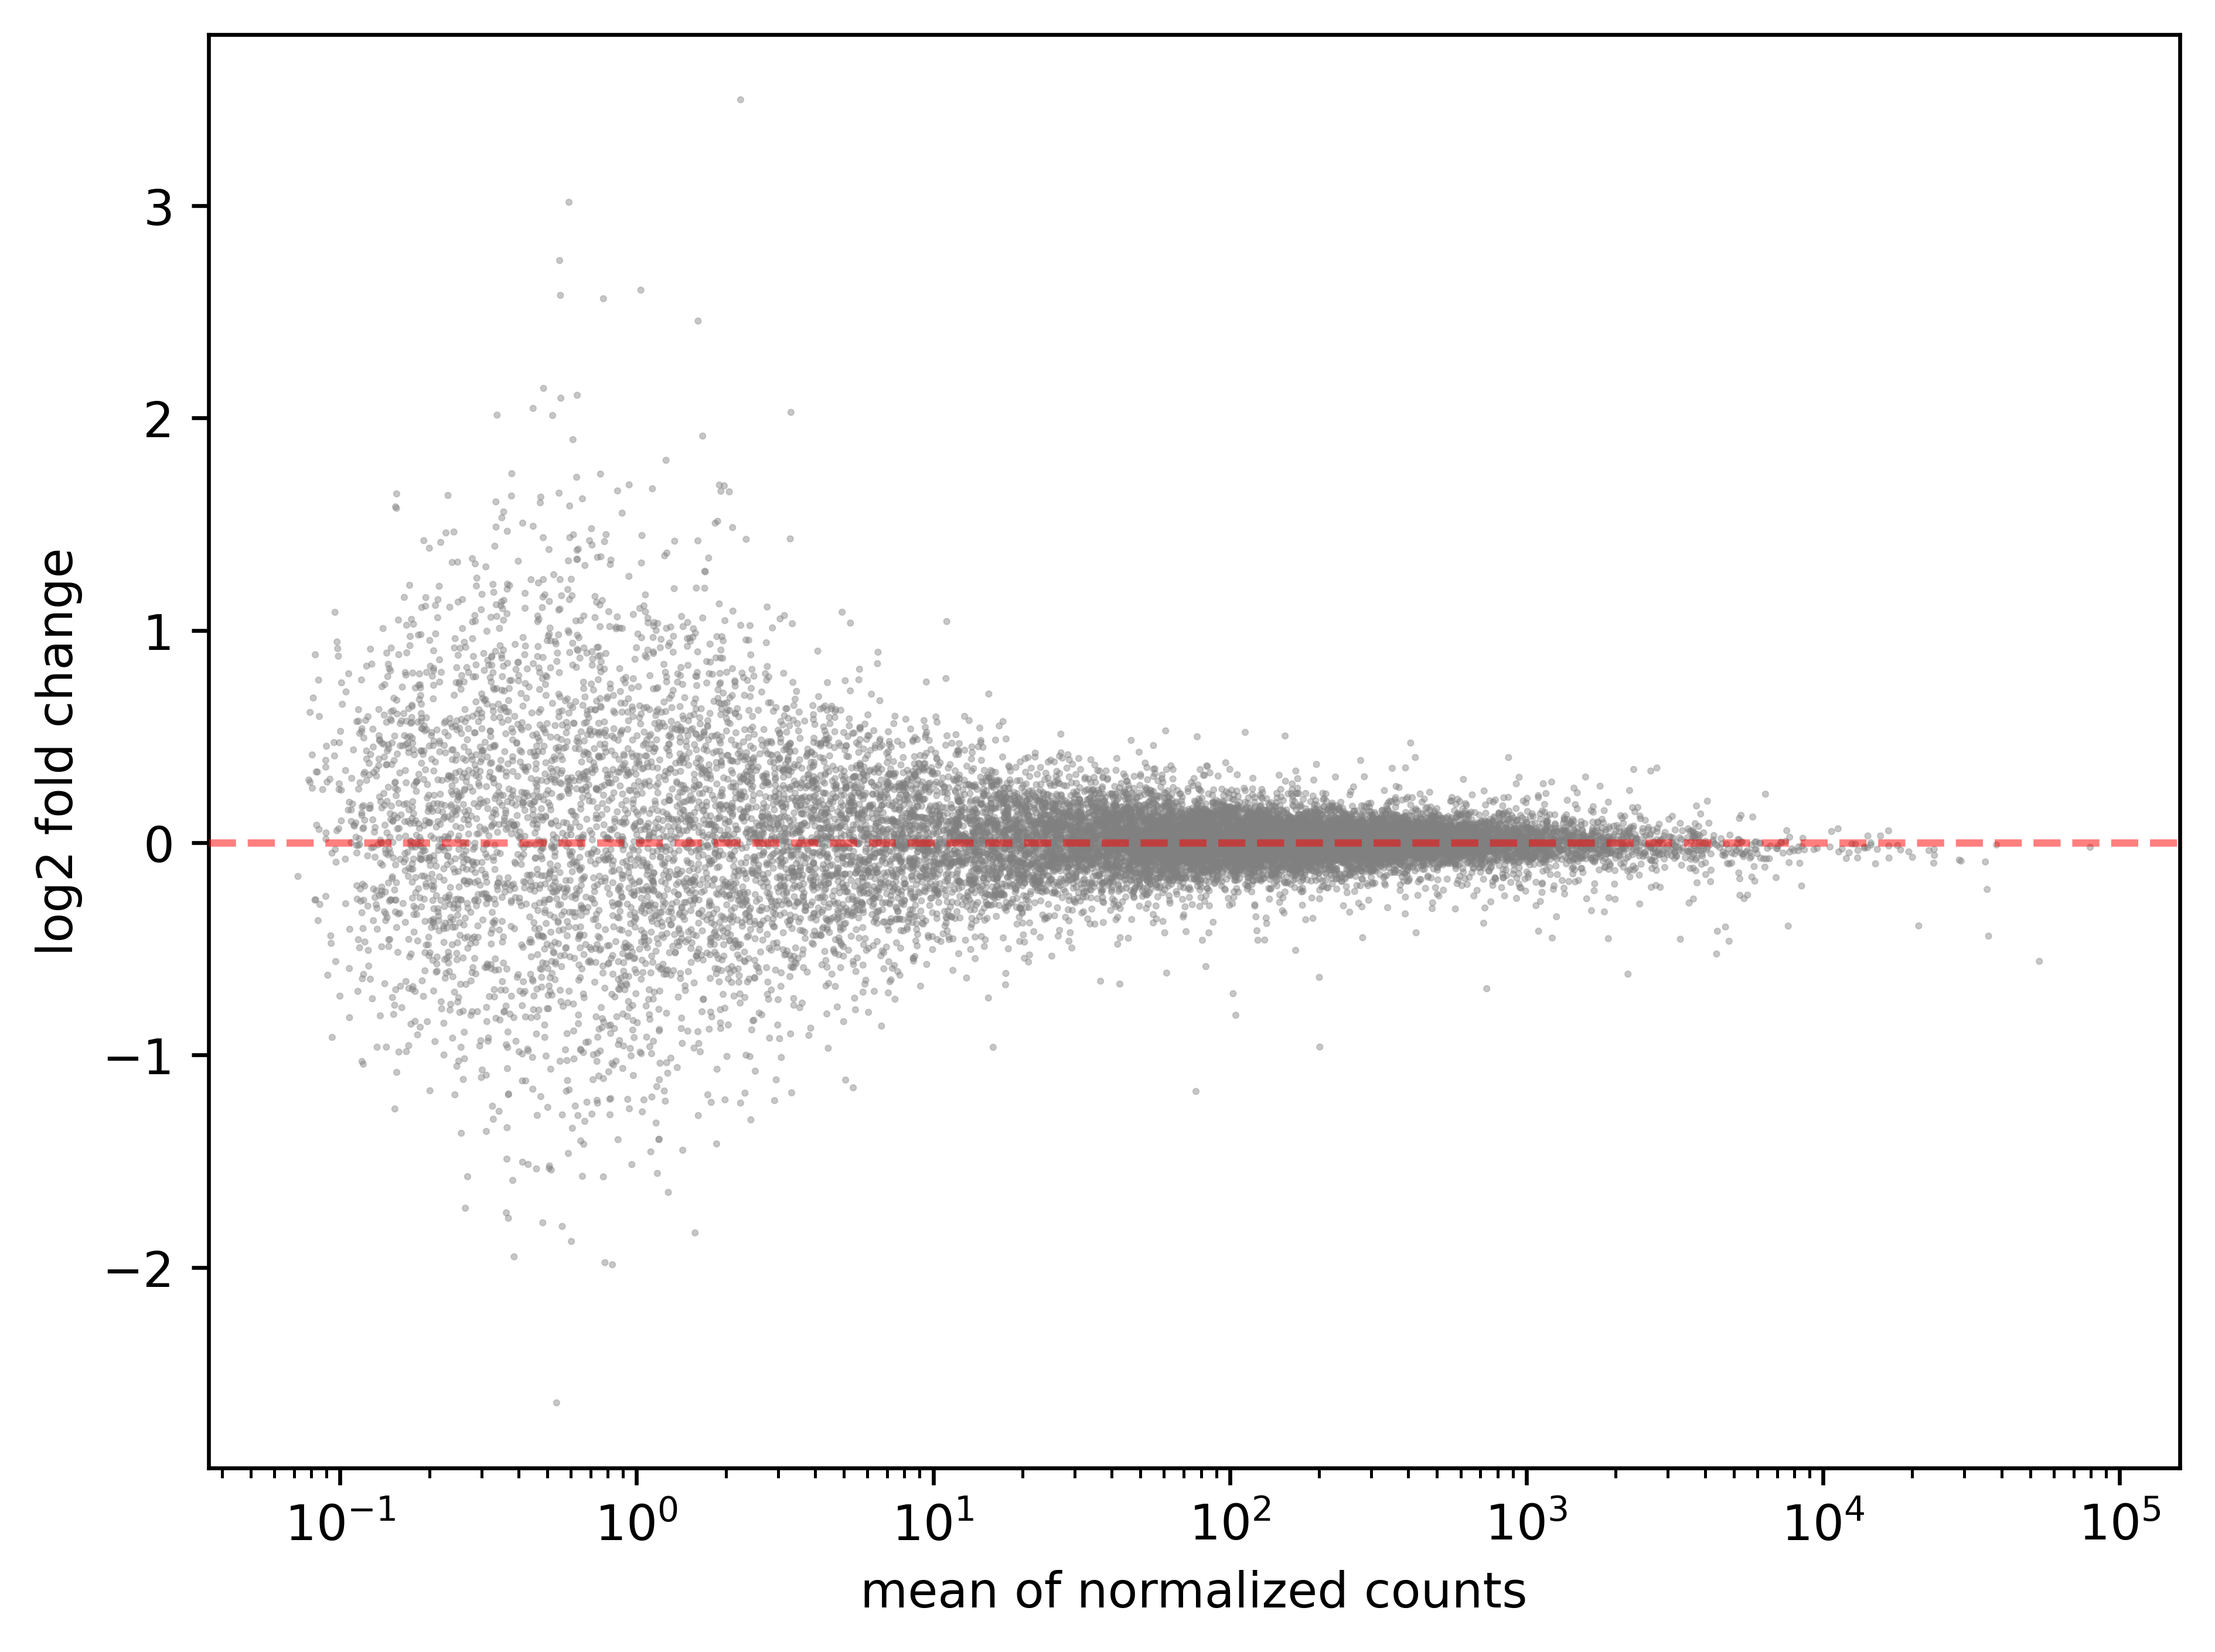

In [132]:
stat_res.plot_MA(log=True, save_path=None)

In [135]:
stat_res.results_df[stat_res.results_df.pvalue < 0.05]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GCSH,7.057665,-0.707329,0.305480,-2.315467,0.020587,0.999914
KCNIP2,3.296341,1.431241,0.439102,3.259473,0.001116,0.999914
TTC30B,14.471377,0.471817,0.222272,2.122703,0.033779,0.999914
SULT1A3,51.860501,0.375298,0.156866,2.392481,0.016735,0.999914
AP002748.5,15.627771,0.340754,0.162129,2.101744,0.035576,0.999914
...,...,...,...,...,...,...
DENND2A,2.758577,0.830169,0.419894,1.977091,0.048031,0.999914
DNMT1,586.403835,0.205011,0.091139,2.249436,0.024485,0.999914
CITED2,493.878599,-0.211583,0.107790,-1.962928,0.049655,0.999914
TALDO1,631.762696,-0.196081,0.092617,-2.117119,0.034250,0.999914


In [138]:
stat_res.results_df[stat_res.results_df.log2FoldChange > 1]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
KCNIP2,3.296341,1.431241,0.439102,3.259473,0.001116,0.999914
CENPA,0.366492,1.467038,1.263023,1.161529,0.245427,0.999914
SLC13A5,0.209806,1.117866,1.829307,0.611087,0.541142,0.999914
GOLGA8M,1.091588,1.057620,0.623151,1.697214,0.089656,0.999914
MAPK15,0.250114,1.133756,1.754526,0.646189,0.518157,0.999914
...,...,...,...,...,...,...
GPR39,0.164709,1.155678,2.396510,0.482234,0.629640,0.999914
H2AB1,0.355791,1.048164,1.244098,0.842509,0.399503,0.999914
USP17L2,0.174078,1.052190,2.326495,0.452264,0.651079,0.999914
KRT23,2.412841,1.022700,0.527545,1.938601,0.052550,0.999914


In [ ]:
shuffled_data["sample"] = shuffled_data["sample"].apply(
    lambda name: name.split("_", 2)[1]
)

In [82]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition CRX-527 vs IMDM


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HUNK,0.333285,-0.820977,1.691481,-0.485360,0.627421,0.999339
KLHL8,105.032021,0.157635,0.142113,1.109219,0.267336,0.884999
ZNF576,38.228072,0.056431,0.161453,0.349519,0.726700,0.999339
UGT1A5,0.000000,NaN,NaN,NaN,NaN,NaN
FCF1,230.579997,0.124109,0.092244,1.345450,0.178480,0.797058
...,...,...,...,...,...,...
GALNT17,0.000000,NaN,NaN,NaN,NaN,NaN
DEPDC4,0.101185,0.705440,3.140298,0.224641,0.822259,0.999339
REL,2675.101178,0.180465,0.199484,0.904658,0.365646,0.953424
RPL23,2782.508697,0.148741,0.113935,1.305490,0.191726,0.814591


In [29]:
p_values = stat_res.p_values

In [40]:
p_values = p_values.dropna()
p_values = p_values.sort_values(ascending=True)

p_sgn = p_values[p_values < 0.05]

In [42]:
len(p_sgn)

298

In [57]:
results_df = stat_res.results_df

In [60]:
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HUNK,0.333285,-0.675909,0.856323,-0.789316,0.429928,0.999961
KLHL8,105.032021,0.102826,0.090313,1.138550,0.254891,0.999961
ZNF576,38.228072,0.044476,0.097545,0.455959,0.648420,0.999961
UGT1A5,0.000000,NaN,NaN,NaN,NaN,NaN
FCF1,230.579997,0.035110,0.058050,0.604823,0.545296,0.999961
...,...,...,...,...,...,...
GALNT17,0.000000,NaN,NaN,NaN,NaN,NaN
DEPDC4,0.101185,0.471334,1.528289,0.308406,0.757773,0.999961
REL,2675.101178,0.044994,0.122648,0.366854,0.713728,0.999961
RPL23,2782.508697,0.028758,0.075610,0.380346,0.703689,0.999961


In [72]:
for index, row in results_df.iterrows():
    if (row["log2FoldChange"] > 0.1) and (row["pvalue"] < 0.05):
        print(index)

ENPP2
PYCR2
TRAP1
ATG4D
PERM1
GGTLC2
TMEM213
C5orf63
RAI2
CYP2D7
HINFP
DTNBP1
REEP6
IFNG
NT5C3B
LCTL
TRMT1L
JCHAIN
FKBPL
MYCT1
IRAK4
SLC4A10
CLLU1-AS1
GATD1
FAM47E
SOGA3
TRMT11
ZNF599
RPP21
LILRB1
LAG3
LONRF1
LLGL1
ARHGAP20
TMEM256
VAMP8
SMTNL1
NLGN2
CASS4
FUZ
GRHL1
SLC22A17
PGLS
GALNT14
FANCG
APOO
ZNF630
KCNS1
CCDC74B
CATIP
PTGDS
B4GALT3
EIF4E3
FGGY
NTPCR
CRIPT
AFG1L
BRDT
ANKRD20A3P
CYP2J2
RTP4
CCDC81
OR10G4
FBL
MINAR1
STX8
NT5C3A
ANO7
SLC35C1
MRPS21
HRH4
SPATA24
ACAD9
CLK3
COG4
ACYP1
PGAP1
AC135050.2
NR2C2AP
OR56A4
SPAG4
MVB12A
IDO1
MPLKIP
RMDN3
C5orf22
SLC25A52
CATSPERB
GSDMB
AC011455.3
PRF1
ADCK2
SULT1A2
UBA7
GPR171
AP000311.1
ACOD1
ILDR2
HPGDS
OR1D2
GALE
PCCB
GPN3
MED7
UQCC3
TMEM234
NEXN
ITGB1BP2
TNFSF10
ZNF18
MTURN
METTL22
IGF1
UPK3BL1
GPN2
COX19
GPR155
CUL4B
CAPS
MRPS27
SAP30L
MSS51
PTPRO
RPH3AL
TFR2
CAV2
CCDC17
ERCC6L
ZCWPW1
AP000781.2
PAK3
DENND2A
MFSD2B


### Cooks filtering
This is optional

<div class="alert alert-info"><h4>Note</h4><p>Note: in the case of the provided synthetic data, there won't be any
  outliers.</p></div>



In [ ]:
if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

### P-value adjustment



In [ ]:
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

### Building a results dataframe
This dataframe is stored in the `results_df` attribute of the `DeseqStats`
class.



In [ ]:
stat_res.summary()

Save everything if SAVE is set to True



In [ ]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stat_results_detailed_pipe.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

### LFC Shrinkage
For visualization or post-processing purposes, it might be suitable to perform
LFC shrinkage. This is implemented by the `lfc_shrink` method.



In [ ]:
stat_res.lfc_shrink(coeff="condition_B_vs_A")

Save everything



In [ ]:
if SAVE:
    with open(
        os.path.join(OUTPUT_PATH, "shrunk_stat_results_detailed_pipe.pkl"), "wb"
    ) as f:
        pkl.dump(stat_res, f)